In [34]:
import nbsetup
import pickle
import copy
import seaborn as sns
import pandas as pd
import itertools
import scipy as sp
import numpy as np
import ensemblepy as ep
import matplotlib.pyplot as plt

In [2]:
with open("daisyscan.pickle", 'rb') as fh:
    scan = pickle.load(fh)

In [3]:
df = scan.dataframe()

In [5]:
incoherences = copy.deepcopy([series.y[-1] for series in scan.y])

In [25]:
def divergences(pmfs):
    divs = []
    for a,b in itertools.combinations(pmfs, 2):
        p_entropy = ep.pooled_entropy([a,b])
        entropies = ep.ensemble_entropies([a,b])
        div = ep.js_divergence(p_entropy, entropies, None)
        divs.append(div)
    return divs
    

In [26]:
cohs = [divergences(inc.histograms) for inc in incoherences]

In [27]:
data = []
for i, c in enumerate(cohs):
    for k in c:
        data.append({'x': scan.x[i], 'c': k})

data = pd.DataFrame(data)

<AxesSubplot:xlabel='x', ylabel='c'>

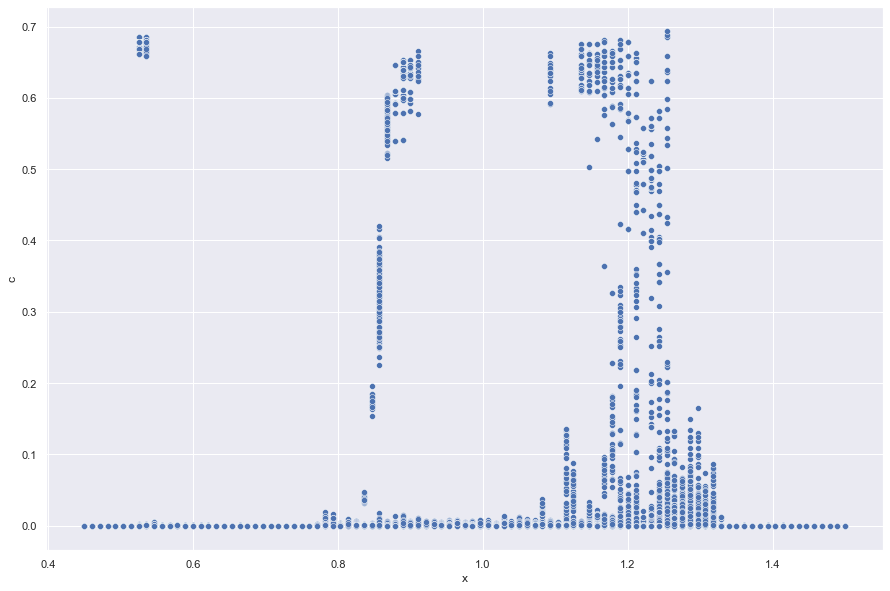

In [28]:
sns.set(rc= {"figure.figsize": (15, 10)})
sns.scatterplot(data=data, x='x', y='c')
sns.lineplot()

In [154]:
def coherences(divs, x, norm=False, srange=range(4,50)):
    divs = np.array(divs)/np.log(4)
    data = []
    for states in srange:
        maxe = np.log(states)
        bins = ep.binspace(0,np.log(4),states)
        for i, row in enumerate(divs):
            hist, _ = np.histogram(row, bins=bins)
            data.append({
                's': states,
                'x': x[i],
                'c': sp.stats.entropy(hist)/(maxe if norm else 1)
            })
    return pd.DataFrame(data)

<AxesSubplot:xlabel='x', ylabel='c'>

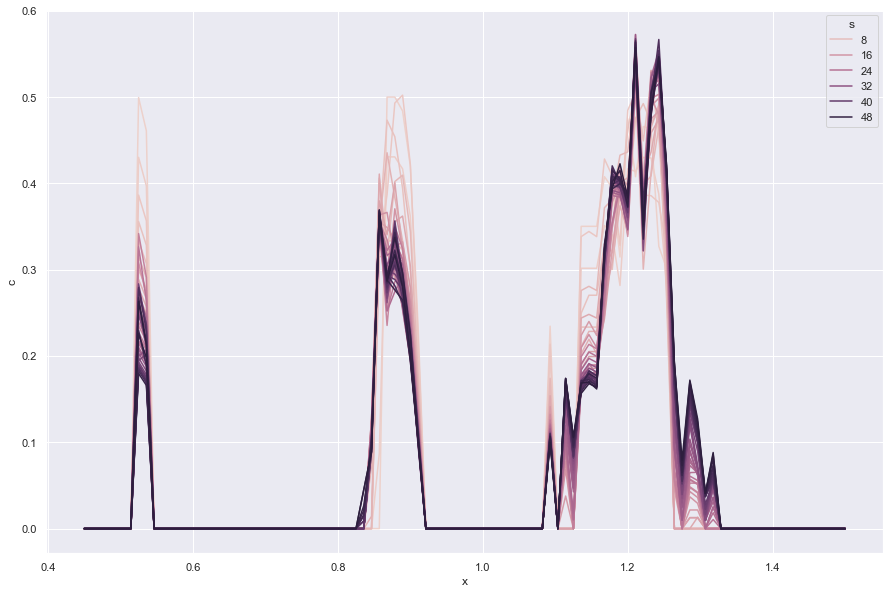

In [155]:
sns.lineplot(data=coherences(cohs, scan.x, True), x='x', y='c', hue='s')

<AxesSubplot:xlabel='x', ylabel='c'>

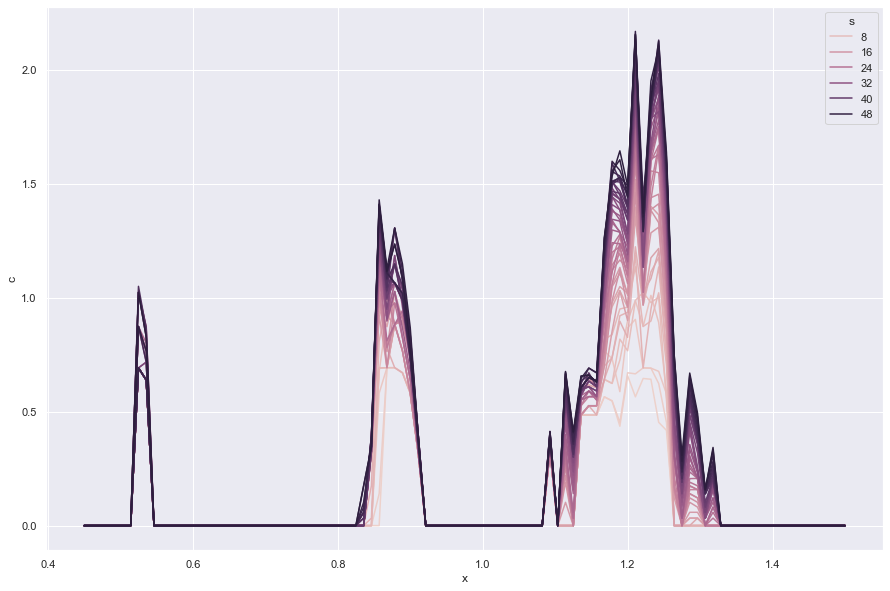

In [156]:
sns.lineplot(data=coherences(cohs, scan.x), x='x', y='c', hue='s')

<AxesSubplot:>

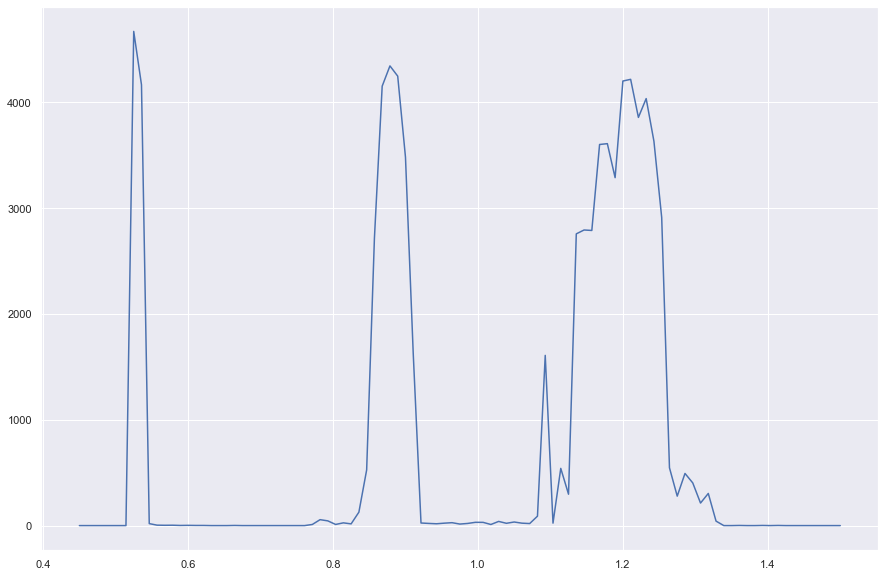

In [127]:
def distances(dd):
    data = []
    for row in dd:
        data.append(np.sum([np.log(1+np.abs(a-b)) for a,b in itertools.combinations(row, 2)]))
    return np.array(data)
        
sns.lineplot(x=scan.x, y=distances(cohs))

In [195]:
N = 2000
distributions = [np.random.uniform(10, size=N), np.random.normal(5, 1, size=N), np.random.normal(5, 0.1, size=N)]

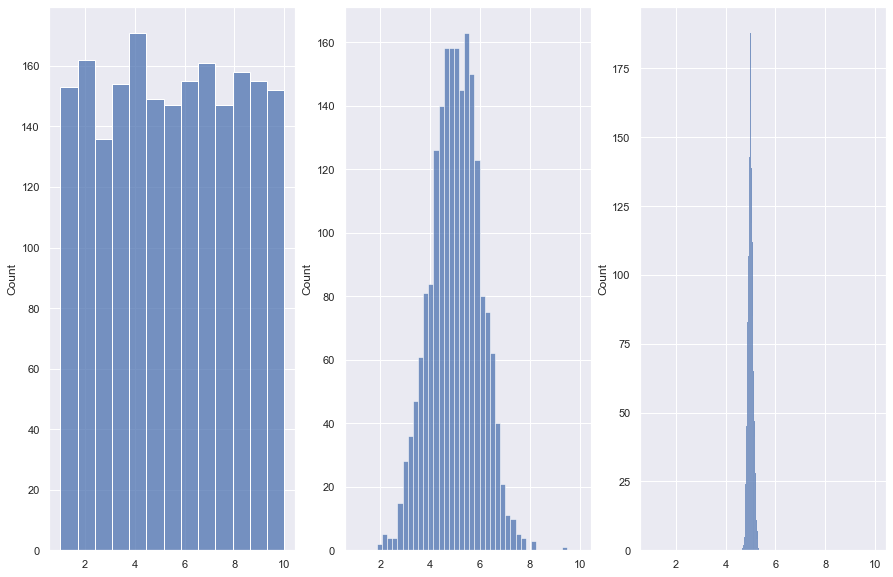

In [197]:
fig, axes = plt.subplots(1, 3, sharex=True)
for i, d in enumerate(distributions):
    sns.histplot(d, ax=axes[i])

In [243]:
def continuous_entropy(data, rng=(0,10), steps=100):
    densities = []
    data = np.array(data)
    # to handle edges
    points = np.concatenate([-data, data, 2*rng[1]-data])
    
    for i in ep.binspace(rng[0], rng[1], steps):
        densities.append(np.sum(1/np.abs(i-points)))
    return np.array(densities)

<ipython-input-243-14711c6f89b6>:8: RuntimeWarning: divide by zero encountered in true_divide
  densities.append(np.sum(1/np.abs(i-points)))
/Users/timjdavey/Projects/complexity/lib/python3.9/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


<AxesSubplot:>

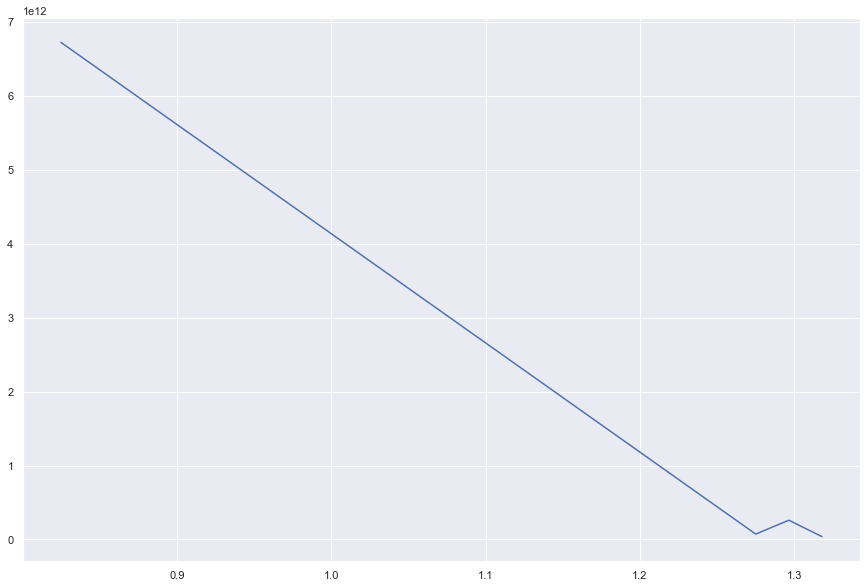

In [246]:
sns.lineplot(x=scan.x, y=[continuous_entropy(c, (0, 0.7)).var() for c in cohs])

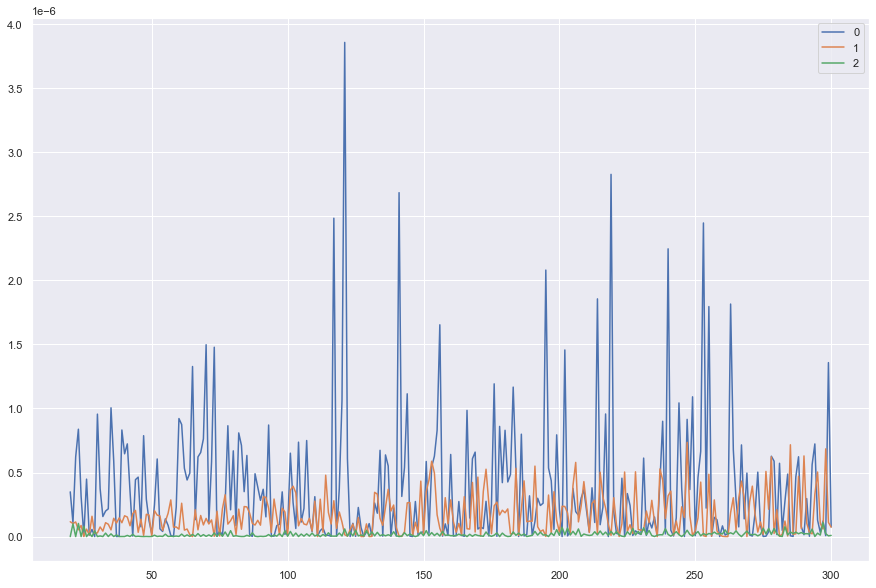

In [228]:
steps = ep.binint(20,300,1000)
for i, d in enumerate(distributions):
    y = []
    for s in steps:
        f = 10/s
        e = continuous_entropy(d, steps=s)
        #print(e.mean(), e.var(), e.mean()/e.var())
        y.append(1/(e.var()*f))
    sns.lineplot(x=steps, y=y, label=i)